# Data augmentation

Based on https://arxiv.org/pdf/1710.01927.pdf

In [3]:
from data_loader import load_data
import numpy as np
import matplotlib.pyplot as plt
import random
from statistics import mean

In [4]:
X, Y, groups, coord = load_data()

## CTRL augmentation

In [5]:
spectrumID = 590
spectrum = X[spectrumID]
x_axis = coord[spectrumID]

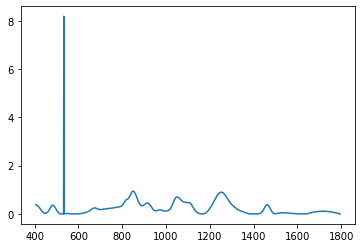

In [6]:
plt.plot(x_axis, spectrum)

In [7]:
def standard_deviation_mean(X):
    full=[]
    for i in X:
        for j in i:
            full.append(j)
    return np.std(full), mean(full)

In [8]:
stdf, meanf = standard_deviation_mean(X)

## Offset : 0,1 x Standard deviation of dataset

In [9]:
def offset_func(spectrum):
    X_offset=[]
    r=random.sample([-0.1,0.1], 1)[0]
    for i in spectrum:
        res = i+(r*stdf)
        if res > 0:
            X_offset.append(res)
        else:
            X_offset.append(0)
    return X_offset

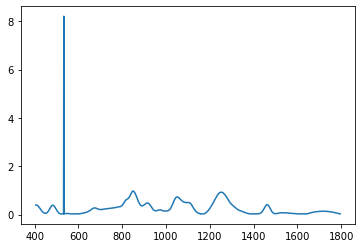

In [10]:
plt.plot(x_axis, offset_func(spectrum))

## Multiplication : 1+- 0,1 x std

In [11]:
def multiplication_func(spectrum):
    X_multiplication=[]
    r=random.uniform(0.9, 1.1)
    for i in spectrum:
        X_multiplication.append(i*r*stdf)
    return X_multiplication

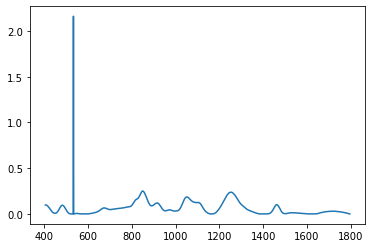

In [12]:
plt.plot(x_axis, multiplication_func(spectrum))

## Gaussian noise

In [13]:
def gaussian_noise_func(spectrum):
    noise = np.random.normal(meanf,stdf,len(spectrum))
    X_gaussian = []
    for i in range(len(spectrum)):
        res = spectrum[i]+noise[i]
        if res > 0:
            X_gaussian.append(res)
        else:
            X_gaussian.append(0)
    return X_gaussian

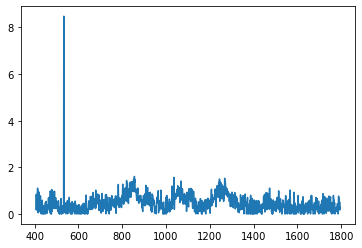

In [14]:
plt.plot(x_axis, gaussian_noise_func(spectrum))

### Sum up of all the methods visually

In [15]:
def data_augmentation(spectrum):
    return offset_func(spectrum), multiplication_func(spectrum), gaussian_noise_func(spectrum)

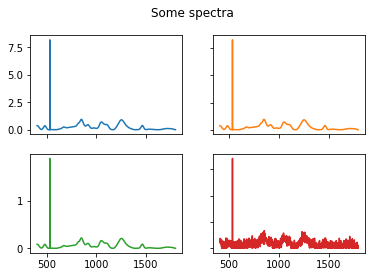

In [16]:
offset, multiplication, gaussian_noise = data_augmentation(spectrum)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('Some spectra')
ax1.plot(x_axis, spectrum)
ax2.plot(x_axis, offset, 'tab:orange')
ax3.plot(x_axis, multiplication, 'tab:green')
ax4.plot(x_axis, gaussian_noise, 'tab:red')

for ax in fig.get_axes():
    ax.label_outer()

## Transfer learning with data augmentation 

Here we decide to augment :
1) the ALS patients that have the lowest number of spectra

2) all the CTRL patients in order to have a more equilibrium between the 2 classes

In [17]:
def get(patient, groups):
    l= np.where(groups == patient)
    start_idx = l[0][0]
    end_idx = l[0][len(l[0])-1]
    idx_range = list(range(start_idx, end_idx+1))
    return idx_range

In [18]:
X_augmented = X
Y_augmented = Y
groups_augmented = groups

In [19]:
#Number of patient 0->29
#als -> 1 or 0
def augment(X_augmented, Y_augmented, groups_augmented, n, als):
    X_added=[]
    spectra_ind = get(n, groups_augmented)
    for spectrumID in spectra_ind:
        spectrum=X_augmented[spectrumID]
        offset, multiplication, gaussian_noise = data_augmentation(spectrum)
        inser = spectrumID
        X_added.append(offset)
        X_added.append(multiplication)
        X_added.append(gaussian_noise)
    last = spectra_ind[-1]+1
    for i in range(len(X_added)):
        X_augmented = np.insert(X_augmented, last+i, X_added[i], axis=0)
        Y_augmented = np.insert(Y_augmented, last+i, als)
        groups_augmented = np.insert(groups_augmented, last+i, n)
    return X_augmented, Y_augmented, groups_augmented

In [20]:
for i in range(15, 20):
    X_augmented, Y_augmented, groups_augmented = augment(X_augmented, Y_augmented, groups_augmented, i, 1)

In [21]:
for i in range(20, 30):
    X_augmented, Y_augmented, groups_augmented = augment(X_augmented, Y_augmented, groups_augmented, i, 0)

## TL method

The below functions are just copy/paste from the previous notebook (with comments)

In [22]:
def split_dataset(num_als, num_ctrl):
    patient_idxs_finetune = []

    x = list(range(0, 20))
    patient_idxs_finetune = random.sample(x,num_als)
    patient_idxs_test = [i for i in x if i not in patient_idxs_finetune]

    x2 = list(range(20, 30))
    patient_idxs_finetune += random.sample(x2,num_ctrl)
    patient_idxs_test += [i for i in x2 if i not in patient_idxs_finetune]

    #Shuffle to avoid implicit leakage (1 the firsts and 0 the lasts)
    random.shuffle(patient_idxs_finetune)
    random.shuffle(patient_idxs_test)
    return patient_idxs_finetune, patient_idxs_test

In [23]:
patient_idxs_finetune, patient_idxs_test = split_dataset(14,6)

In [24]:
import os,sys, time
os.chdir(os.getcwd())
models_dir = 'Bacteria_TL'
sys.path.append(models_dir)

models = ['pretrained_model.ckpt', 'finetuned_model.ckpt', 'clinical_pretrained_model.ckpt']
from resnet import ResNet
import os
import torch

In [25]:
# CNN parameters
layers = 6
hidden_size = 100
block_size = 2
hidden_sizes = [hidden_size] * layers
num_blocks = [block_size] * layers
input_dim = 1174
in_channels = 64
batch_size=10
n_classes = 2 # instead of 30, we use the 2 empiric groupings
os.environ['CUDA_VISIBLE_DEVICES'] = '{}'.format(0)
cuda = torch.cuda.is_available()

In [26]:
#Remove last layers
def removekey(d, listofkeys):
    r = dict(d)
    for key in listofkeys:
        print('key: {} is removed'.format(key))
        r.pop(key)
    return r

In [27]:
def load_model(n=0):
    cnn = ResNet(hidden_sizes, num_blocks, input_dim=input_dim,
                    in_channels=in_channels, n_classes=n_classes)
    if cuda: cnn.cuda()

    checkpoint = torch.load(models_dir + '/' + models[n], map_location=lambda storage, loc: storage)
    mod_weights = removekey(checkpoint, ['linear.weight', 'linear.bias'])
    cnn.load_state_dict(mod_weights, strict=False)
    return cnn, mod_weights, checkpoint

In [28]:
#20 patients into 4 groups of 5 patients
def group_patients(patient_idxs_finetune):
    patient_idxs = []
    x = patient_idxs_finetune
    for i in range(4):
        l = random.sample(x,5)
        patient_idxs.append(l)
        x = [i for i in x if i not in l]
    return patient_idxs

In [29]:
# Sample train/val/te spectra -> each group [train, train, train, val, test]
def custom_split_finetuning(patient_idxs, groups):
    idx_tr, idx_val, idx_te = [], [], []
    for group_idx, patient_list in enumerate(patient_idxs):
        print('Group {} patients'.format(group_idx))
        print(' Tr: {}'.format(patient_list[:3]))
        print(' Val: {}'.format(patient_list[3]))
        print(' Te : {}'.format(patient_list[4]))
        for j, patient in enumerate(patient_list):
            l= np.where(groups == patient)
            start_idx = l[0][0]
            end_idx = l[0][len(l[0])-1]
            idx_range = list(range(start_idx, end_idx+1))
            np.random.shuffle(idx_range) #-> do we shuffle ? 
            print(patient, idx_range, len(idx_range))
            if j < 3:
                idx_tr.extend(idx_range)
            elif j ==3:
                idx_val.extend(idx_range)
            else:
                idx_te.extend(idx_range)
    return idx_tr, idx_val, idx_te

In [30]:
from datasets import spectral_dataloader
from training import run_epoch
from torch import optim

In [31]:
# Fine-tune CNN
def finetune(cnn, idx_tr, idx_val, idx_te, X, Y):
    epochs = 1
    batch_size = 10
    #t0 = time()
    # Set up Adam optimizer
    optimizer = optim.Adam(cnn.parameters(), lr=1e-3, betas=(0.5, 0.999))
    # Set up dataloaders
    dl_tr = spectral_dataloader(X, Y, idxs=idx_tr,
        batch_size=batch_size, shuffle=True)
    dl_val = spectral_dataloader(X, Y, idxs=idx_val,
        batch_size=batch_size, shuffle=False)
    dl_te = spectral_dataloader(X, Y, idxs=idx_te,
        batch_size=batch_size, shuffle=False)
    # Fine-tune CNN for first fold
    best_val = 0
    no_improvement = 0
    max_no_improvement = 5
    print('Starting fine-tuning!')
    for epoch in range(epochs):
        #print(' Epoch {}: {:0.2f}s'.format(epoch+1, time()-t0))
        # Train
        acc_tr, loss_tr = run_epoch(epoch, cnn, dl_tr, cuda,
            training=True, optimizer=optimizer)
        print('  Train acc: {:0.2f}'.format(acc_tr))
        # Val
        acc_val, loss_val = run_epoch(epoch, cnn, dl_val, cuda,
            training=False, optimizer=optimizer)
        print('  Val acc: {:0.2f}'.format(acc_val))
        # Test
        acc_te, loss_te = run_epoch(epoch, cnn, dl_te, cuda,
            training=False, optimizer=optimizer)
        print('  Test acc: {:0.2f}'.format(acc_te))
        # Check performance for early stopping
        if acc_val > best_val or epoch == 0:
            best_val = acc_val
            no_improvement = 0
        else:
            no_improvement += 1
        if no_improvement >= max_no_improvement:
            print('Finished after {} epochs!'.format(epoch+1))
            break
    #print('Finished: {:0.2f}s'.format(time()-t0))

In [32]:
from training import get_predictions
from scipy import stats
from statistics import mean

In [33]:
#1/ Getting test indices
def get_test_indices(patient_idxs_test, groups):
    idx_te = []
    for group_idx in patient_idxs_test:
        l= np.where(groups == group_idx)
        start_idx = l[0][0]
        end_idx = l[0][len(l[0])-1]
        idx_te += list(range(start_idx, end_idx+1))
    return idx_te

In [34]:
def predict(cnn, idx_te, X, Y):
    #1/ Predicting on finetuned model
    dl_te = spectral_dataloader(X, Y, idxs=idx_te,
        batch_size=batch_size, shuffle=False)
    #t0 = time()
    y_hat = get_predictions(cnn, dl_te, cuda)
    #print('Finished: {:0.2f}s'.format(time()-t0))
    #2/ Getting the right Y indices for comparing
    Y_l = []
    for i in range(len(Y)):
        if i in idx_te:
            Y_l.append(Y[i])
    #3/ Computing accuracy and std
    acc = (y_hat == Y_l).mean()
    print('Accuracy: {:0.1f}%'.format(100*acc))
    return acc, Y_l, y_hat

In [35]:
def results(num_model, idx_tr, idx_val, idx_te, fn_idx_te, X, Y):
    list_acc=[]
    #Average on 10 times
    for i in range(10):
        print(i+1)
        #Load model
        cnn, _, _ = load_model(num_model)
        #finetune it owith custom split
        finetune(cnn, idx_tr, idx_val, idx_te, X, Y)
        #get accuracy to make an average and std on test set
        list_acc.append(predict(cnn, fn_idx_te, X, Y)[0])
    return list_acc

## Let's compare the results with/witout data augmentation

### Repartition for tests

In [36]:
num_als=13
num_ctrl = 7
patient_idxs_finetune, patient_idxs_test = split_dataset(num_als, num_ctrl)
patient_idxs = group_patients(patient_idxs_finetune)

#### WITHOUT

In [37]:
idx_tr, idx_val, idx_te = custom_split_finetuning(patient_idxs, groups)

Group 0 patients
 Tr: [11, 10, 16]
 Val: 25
 Te : 22
11 [299, 305, 303, 309, 307, 302, 308, 304, 312, 300, 310, 301, 306, 311] 14
10 [286, 293, 287, 290, 292, 297, 282, 283, 281, 294, 289, 285, 295, 291, 288, 284, 296, 298, 280] 19
16 [353, 361, 362, 357, 359, 355, 360, 354, 356, 358] 10
25 [546, 544, 548, 549, 543, 542, 547, 545, 550] 9
22 [469, 479, 472, 475, 470, 483, 473, 471, 482, 480, 476, 477, 481, 478, 474] 15
Group 1 patients
 Tr: [1, 3, 0]
 Val: 29
 Te : 13
1 [72, 69, 63, 76, 67, 66, 64, 74, 73, 62, 70, 61, 65, 68, 60, 75, 77, 71] 18
3 [141, 147, 144, 142, 114, 143, 123, 139, 122, 119, 118, 135, 127, 130, 136, 116, 126, 134, 148, 140, 133, 124, 132, 120, 125, 137, 146, 131, 149, 138, 145, 115, 121, 129, 117, 128] 36
0 [27, 2, 28, 0, 56, 12, 21, 10, 51, 32, 5, 16, 57, 38, 3, 37, 53, 24, 1, 25, 29, 9, 8, 17, 13, 42, 40, 30, 23, 43, 39, 18, 54, 7, 11, 48, 31, 52, 19, 44, 22, 47, 14, 36, 46, 33, 4, 6, 41, 35, 55, 45, 20, 50, 58, 49, 15, 26, 34, 59] 60
29 [586, 582, 590, 588, 581,

In [38]:
n1 = len([i for i in idx_tr if i < 393])
n2 = len([i for i in idx_val if i < 393])
n3 = len([i for i in idx_te if i < 393])
print("Number of samples to train the finetune model : ", len(idx_tr), " -> ALS : ", n1, ", CTRL : ", len(idx_tr)-n1)
print("Number of samples to validate the finetune model : ", len(idx_val), " -> ALS : ", n2, ", CTRL : ", len(idx_val)-n2)
print("Number of samples to test the finetune model : ", len(idx_te), " -> ALS : ", n3, ", CTRL : ", len(idx_te)-n3)

Number of samples to train the finetune model :  289  -> ALS :  203 , CTRL :  86
Number of samples to validate the finetune model :  70  -> ALS :  51 , CTRL :  19
Number of samples to test the finetune model :  46  -> ALS :  20 , CTRL :  26


In [39]:
fn_idx_te = get_test_indices(patient_idxs_test, groups)
m= len([i for i in fn_idx_te if i < 393])
print("Number of samples to test : ", len(fn_idx_te), " -> ALS : ", m, ", CTRL : ", len(fn_idx_te)-m)

Number of samples to test :  186  -> ALS :  119 , CTRL :  67


In [40]:
list_acc = results(1, idx_tr, idx_val, idx_te, fn_idx_te, X, Y)
print(mean(list_acc))
print(np.std(list_acc))

1
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
  Train acc: 84.08
  Val acc: 85.71
  Test acc: 97.83
Accuracy: 61.3%
2
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
  Train acc: 89.27
  Val acc: 85.71
  Test acc: 97.83
Accuracy: 61.8%
3
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
  Train acc: 87.20
  Val acc: 85.71
  Test acc: 97.83
Accuracy: 62.4%
4
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
  Train acc: 88.93
  Val acc: 87.14
  Test acc: 97.83
Accuracy: 62.4%
5
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
  Train acc: 89.62
  Val acc: 84.29
  Test acc: 93.48
Accuracy: 63.4%
6
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
  Train acc: 90.31
  Val acc: 85.71
  Test acc: 97.83
Accuracy: 60.8%
7
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
  Trai

### WITH

In [41]:
idx_tr, idx_val, idx_te = custom_split_finetuning(patient_idxs, groups_augmented)

Group 0 patients
 Tr: [11, 10, 16]
 Val: 25
 Te : 22
11 [311, 303, 308, 299, 310, 305, 309, 306, 312, 304, 307, 300, 301, 302] 14
10 [289, 294, 298, 296, 283, 287, 284, 295, 291, 293, 282, 285, 288, 280, 290, 297, 281, 286, 292] 19
16 [384, 408, 404, 405, 398, 392, 390, 412, 414, 415, 409, 387, 389, 418, 413, 401, 422, 383, 417, 391, 410, 402, 386, 421, 407, 388, 420, 393, 395, 411, 394, 400, 406, 416, 396, 399, 403, 419, 385, 397] 40
25 [1150, 1169, 1146, 1143, 1156, 1172, 1163, 1144, 1164, 1140, 1141, 1167, 1171, 1147, 1142, 1154, 1152, 1151, 1170, 1159, 1160, 1165, 1149, 1161, 1174, 1153, 1157, 1173, 1166, 1168, 1155, 1139, 1148, 1145, 1162, 1158] 36
22 [886, 873, 890, 857, 859, 897, 882, 877, 863, 869, 862, 879, 872, 906, 853, 898, 868, 855, 850, 875, 856, 860, 852, 903, 848, 884, 894, 892, 887, 904, 893, 902, 889, 878, 896, 901, 867, 858, 899, 900, 880, 865, 861, 864, 866, 888, 905, 849, 885, 870, 876, 883, 871, 874, 881, 854, 895, 847, 891, 851] 60
Group 1 patients
 Tr: [1, 3, 0]

In [42]:
n1 = len([i for i in idx_tr if i < 393])
n2 = len([i for i in idx_val if i < 393])
n3 = len([i for i in idx_te if i < 393])
print("Number of samples to train the finetune model : ", len(idx_tr), " -> ALS : ", n1, ", CTRL : ", len(idx_tr)-n1)
print("Number of samples to validate the finetune model : ", len(idx_val), " -> ALS : ", n2, ", CTRL : ", len(idx_val)-n2)
print("Number of samples to test the finetune model : ", len(idx_te), " -> ALS : ", n3, ", CTRL : ", len(idx_te)-n3)

Number of samples to train the finetune model :  577  -> ALS :  203 , CTRL :  374
Number of samples to validate the finetune model :  127  -> ALS :  51 , CTRL :  76
Number of samples to test the finetune model :  124  -> ALS :  20 , CTRL :  104


In [43]:
fn_idx_te = get_test_indices(patient_idxs_test, groups_augmented)
m= len([i for i in fn_idx_te if i < 393])
print("Number of samples to test : ", len(fn_idx_te), " -> ALS : ", m, ", CTRL : ", len(fn_idx_te)-m)

Number of samples to test :  507  -> ALS :  119 , CTRL :  388


In [44]:
list_acc = results(1, idx_tr, idx_val, idx_te, fn_idx_te, X_augmented, Y_augmented)
print(mean(list_acc))
print(np.std(list_acc))

1
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
  Train acc: 91.16
  Val acc: 74.02
  Test acc: 100.00
Accuracy: 74.4%
2
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
  Train acc: 92.89
  Val acc: 70.08
  Test acc: 100.00
Accuracy: 76.3%
3
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
  Train acc: 93.07
  Val acc: 73.23
  Test acc: 100.00
Accuracy: 74.8%
4
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
  Train acc: 93.41
  Val acc: 76.38
  Test acc: 100.00
Accuracy: 76.1%
5
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
  Train acc: 93.76
  Val acc: 76.38
  Test acc: 100.00
Accuracy: 74.6%
6
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
  Train acc: 92.37
  Val acc: 77.95
  Test acc: 100.00
Accuracy: 71.2%
7
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!


## Confusion matrix TL + data augmentation 

In [45]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
cnn, _, _ = load_model(1)
#finetune it owith custom split
finetune(cnn, idx_tr, idx_val, idx_te, X_augmented, Y_augmented)
acc, y, y_hat = predict(cnn, fn_idx_te, X_augmented, Y_augmented)

key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
  Train acc: 94.11
  Val acc: 77.17
  Test acc: 100.00
Accuracy: 74.4%


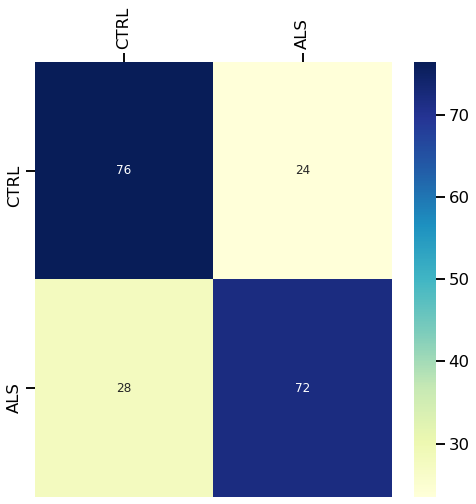

In [47]:
# Plot confusion matrix
sns.set_context("talk", rc={"font":"Helvetica", "font.size":12})
label = ["CTRL", "ALS"]
cm = confusion_matrix(y, y_hat, labels=[0, 1])
plt.figure(figsize=(8, 8))
cm = 100 * cm / cm.sum(axis=1)[:,np.newaxis]
ax = sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='0.0f',
                 xticklabels=label, yticklabels=label)
ax.xaxis.tick_top()
plt.xticks(rotation=90) 
plt.show()